In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')
device

Running on GPU
NVIDIA GeForce GTX 1050 Ti with Max-Q Design


device(type='cuda', index=0)

In [4]:
#OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
#OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

#Run this block as a work-around
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
train_dataset = torchvision.datasets.CIFAR10("./dataCIFAR10", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10("./dataCIFAR10", transform=torchvision.transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

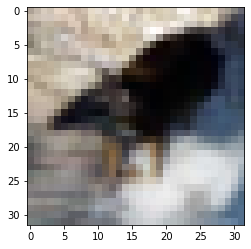

In [5]:
train_iter = iter(train_loader) # converttrain loader to an iterator

batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
plt.imshow(image.permute(1,2,0))
plt.show()

In [6]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1, 2)
        self.pool2 = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        
        self.ll1 = nn.Linear(1024, 120)
        self.ll2 = nn.Linear(120, 84)
        self.ll3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #x = x.view(-1, 16*5*5)
        x = self.flat(x)
        x = F.relu(self.ll1(x))
        x = F.relu(self.ll2(x))
        x = self.ll3(x) #No need for softmax
        return x

In [7]:
model = CNN()

model.to(device) # specify that this model will be stored on the device you chose earlier (GPU or CPU)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (ll1): Linear(in_features=1024, out_features=120, bias=True)
  (ll2): Linear(in_features=120, out_features=84, bias=True)
  (ll3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
#loss function
criterion = nn.CrossEntropyLoss()

In [9]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
#
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()

    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        batch_outputs = model(batch_inputs)
        loss = criterion(batch_outputs, batch_labels)
        loss.backward()
        optimizer.step()

    print('End of epoch loss:', round(loss.item(), 3))

In [11]:
#
def test(model, test_loader, device):
    # we've manually specified the classes - these are from the cifar-10 dataset
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    model.eval()
    correct = 0

    for batch_inputs, batch_labels in test_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        predictions = model(batch_inputs).argmax(axis=1)
        correct += (predictions == batch_labels).sum().item()
        
    print('End of epoch accuracy:', 100*correct/len(test_dataset), '%')
    #print('pred: ', predictions)

    # visualizing the current model's performance - no changes required
    for i in range(4):
        print('Guess:', classes[predictions[i]], '| Label:', classes[batch_labels[i]])
        plt.imshow(batch_inputs[i].cpu().permute(1,2,0))
        plt.show()

End of epoch loss: 2.291
End of epoch accuracy: 10.0 %
Guess: deer | Label: horse


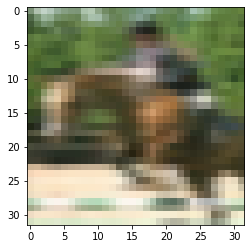

Guess: deer | Label: cat


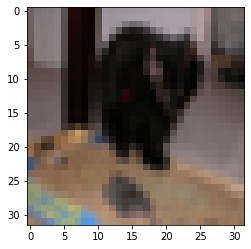

Guess: deer | Label: car


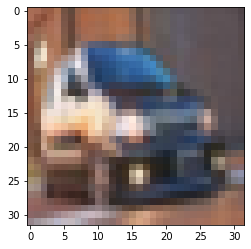

Guess: deer | Label: cat


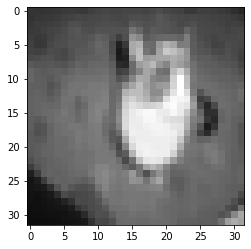

KeyboardInterrupt: 

In [12]:
for epoch in range(1,6):
    print()
    train_one_epoch(model, train_loader, optimizer, criterion, device) #
    test(model, test_loader, device)#

In [ ]:
# save weights
torch.save(model.state_dict(), "./myCIFARModel.pt")

In [ ]:
myNewModel = CNN()

modelWeights = torch.load("./myCIFARModel.pt")

myNewModel.load_state_dict(modelWeights)